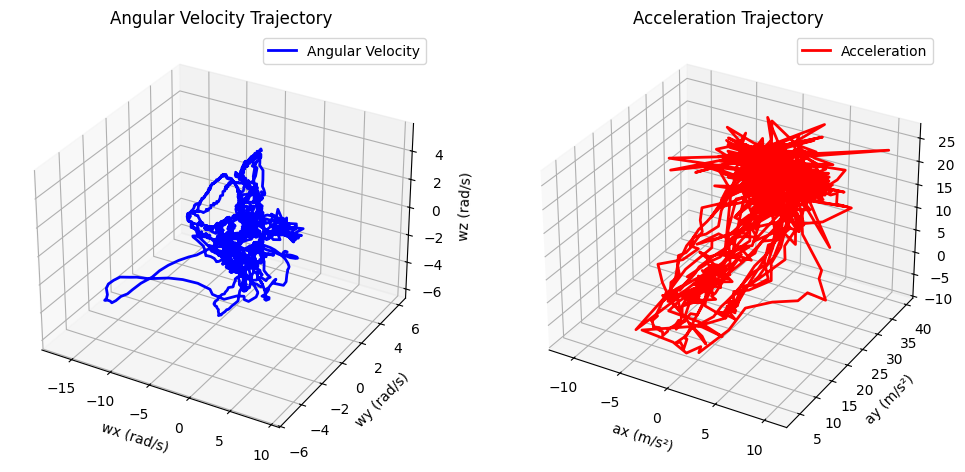

In [2]:
# 由于执行状态被重置，需要重新加载数据并执行代码

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 重新加载 IMU 数据文件
imu_file_path = "imu.csv"

# 读取 IMU 数据
imu_data = pd.read_csv(imu_file_path, sep=" ", comment="#", header=None, names=["ts", "wx", "wy", "wz", "ax", "ay", "az"])

# 归一化时间（从 0 开始）
imu_data["t"] = imu_data["ts"] - imu_data["ts"].iloc[0]

# 创建 3D 轨迹图
fig = plt.figure(figsize=(12, 6))

# 角速度轨迹
ax1 = fig.add_subplot(121, projection="3d")
ax1.plot(imu_data["wx"], imu_data["wy"], imu_data["wz"], color="blue", linewidth=2, label="Angular Velocity")
ax1.set_xlabel("wx (rad/s)")
ax1.set_ylabel("wy (rad/s)")
ax1.set_zlabel("wz (rad/s)")
ax1.set_title("Angular Velocity Trajectory")
ax1.legend()
ax1.grid(True)

# 加速度轨迹
ax2 = fig.add_subplot(122, projection="3d")
ax2.plot(imu_data["ax"], imu_data["ay"], imu_data["az"], color="red", linewidth=2, label="Acceleration")
ax2.set_xlabel("ax (m/s²)")
ax2.set_ylabel("ay (m/s²)")
ax2.set_zlabel("az (m/s²)")
ax2.set_title("Acceleration Trajectory")
ax2.legend()
ax2.grid(True)

# 显示图像
plt.show()


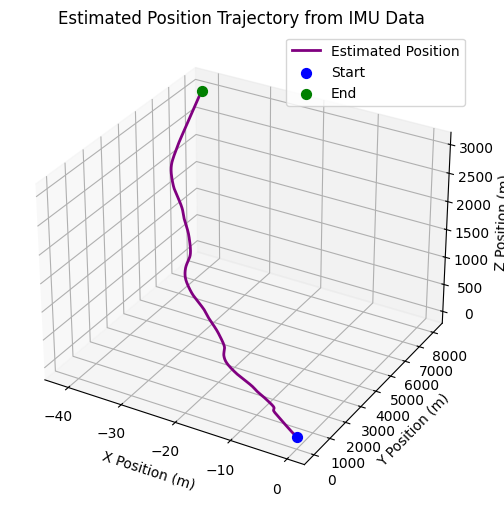

In [3]:
# 计算位置轨迹（基于加速度进行数值积分）

# 设定初始位置和速度
dt = np.mean(np.diff(imu_data["t"]))  # 计算平均时间步长
position = np.zeros((len(imu_data), 3))  # 存储位置 (px, py, pz)
velocity = np.zeros((len(imu_data), 3))  # 存储速度 (vx, vy, vz)

# 数值积分计算位置（使用梯形积分法）
for i in range(1, len(imu_data)):
    velocity[i] = velocity[i - 1] + np.array([imu_data["ax"][i], imu_data["ay"][i], imu_data["az"][i]]) * dt
    position[i] = position[i - 1] + velocity[i] * dt

# 创建 3D 轨迹图（位置轨迹）
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

# 绘制位置轨迹
ax.plot(position[:, 0], position[:, 1], position[:, 2], color="purple", linewidth=2, label="Estimated Position")

# 标记起点和终点
ax.scatter(position[0, 0], position[0, 1], position[0, 2], color="blue", s=50, label="Start")
ax.scatter(position[-1, 0], position[-1, 1], position[-1, 2], color="green", s=50, label="End")

# 设置轴标签和标题
ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)")
ax.set_zlabel("Z Position (m)")
ax.set_title("Estimated Position Trajectory from IMU Data")
ax.legend()
ax.grid(True)

# 显示图像
plt.show()


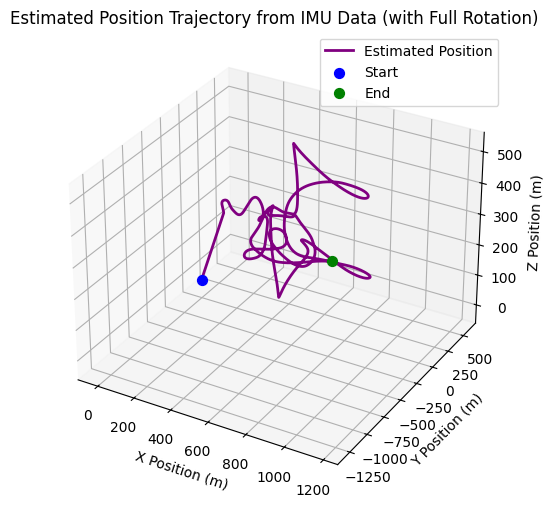

In [6]:
# 计算位置轨迹，同时结合完整的角速度 (wx, wy, wz) 进行三维旋转调整

from scipy.spatial.transform import Rotation as R

# 设定初始位置、速度和航向角（roll, pitch, yaw）
dt = np.mean(np.diff(imu_data["t"]))  # 计算平均时间步长
position = np.zeros((len(imu_data), 3))  # 存储位置 (px, py, pz)
velocity = np.zeros((len(imu_data), 3))  # 存储速度 (vx, vy, vz)
orientation = np.zeros((len(imu_data), 3))  # 存储姿态角 (roll, pitch, yaw)

# 数值积分计算位置和姿态角（使用梯形积分法）
for i in range(1, len(imu_data)):
    # 计算姿态角 (roll, pitch, yaw) 基于 (wx, wy, wz) 角速度积分
    orientation[i] = orientation[i - 1] + np.array([imu_data["wx"][i], imu_data["wy"][i], imu_data["wz"][i]]) * dt

    # 计算速度（加速度积分）
    velocity[i] = velocity[i - 1] + np.array([imu_data["ax"][i], imu_data["ay"][i], imu_data["az"][i]]) * dt

    # 使用旋转矩阵修正速度方向，使其符合姿态变化
    rotation = R.from_euler('xyz', orientation[i], degrees=False)  # 计算旋转矩阵
    velocity_rotated = rotation.apply(velocity[i])  # 旋转速度向量

    # 计算位置（速度积分）
    position[i] = position[i - 1] + velocity_rotated * dt

# 创建 3D 轨迹图（位置轨迹）
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

# 绘制位置轨迹
ax.plot(position[:, 0], position[:, 1], position[:, 2], color="purple", linewidth=2, label="Estimated Position")

# 标记起点和终点
ax.scatter(position[0, 0], position[0, 1], position[0, 2], color="blue", s=50, label="Start")
ax.scatter(position[-1, 0], position[-1, 1], position[-1, 2], color="green", s=50, label="End")

# 设置轴标签和标题
ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)")
ax.set_zlabel("Z Position (m)")
ax.set_title("Estimated Position Trajectory from IMU Data (with Full Rotation)")
ax.legend()
ax.grid(True)

# 显示图像
plt.show()
